In [104]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
#we need to read the file
#../input_data/trajNaCl.pdb
#500 timeframes

#bash command to filter
#grep ATOM trajNaCl.pdb | tr -s ' ' | cut -d' ' -f6-8 > filter_trajNaCl.txt

In [106]:
def data_init():
    data = np.loadtxt("../input_data/filter_trajNaCl.txt") #500 blocks of 40 lines
    cell = 31.47
    bins = 300 #total number of bins, also affects the amount of values g gets
    ngr = 0 # what is ngr for ?
    delg = cell/(2*bins) #delg is bin size
    g = np.zeros(bins) 
    #First chunk over
    chunk = 40
    npart = chunk*501 #amount of particles, 20040
    return data, cell, bins, ngr, delg, g, npart, chunk

In [107]:
#Based on Frenkel
def rdf(g, ngr, cell, data, delg, npart, chunk):
    for k in range(0, npart, chunk): #k for the different chunks/timeframes
        ngr = ngr + 1   #not very improtant, only used for normalization
        for i in range(k+0, k+chunk-1):
            for j in range(i+1, k+chunk): #This should be OK
                #distance between a particle pair
                r = data[i]-data[j]
                #implement periodic boundary conditions
                r = r - cell*np.round(r/cell) # ok
                r = np.linalg.norm(r) # ok
                #half-box check & contribution
                if r <= cell/2: #what is the reasoning here? - makes sense now, maximum radius, otherwise outside of the box, invalid data
                    l = int(r/(delg))
                    g[l] = g[l] + 2
    return g, ngr

In [108]:
#Attempt to my own understanding - not used at all
def rdf_variant(cell, data, npart, chunk):
    bins = 7
    d = np.zeros(bins)
    rMax = bins # should be connected to the number of bins somehow
    #for a cell of size 31, bins = 7 makes the most sense for an rMax of 14-15
    for k in range(0, npart, chunk):
        for i in range(k+0, k+chunk-1):
            for j in range(i+1, k+chunk):
                r = data[i]-data[j]
                r = r - cell*np.round(r/cell)
                r = np.linalg.norm(r)
                index = np.round(bins*(r/rMax)) #Finding the shell that the particle is in
                d[index] = d[index] + 2 #+1 or +2? +2 makes more sense
    return d

In [109]:
def grdf(g, ngr, bins, npart, cell):
    rho = npart/(cell**3)
    r = []
    for i in range(0, bins): #i in [0, bins), inc +1
        r.append(delg*(i+0.5))  #So this will be the x-axis
        vol = ((i+1)**3  - i**3 )*delg**3 #what?
        nid = (4/3)*np.pi*vol*rho
        #vol and nid, seem a bit weird to me
        g[i] = g[i]/(ngr*npart*nid)  
        #This is the normalization part, I need a a proper value for rho
        #Not so important for now
    return g, r

In [110]:
data, cell, bins, ngr, delg, g, npart, chunk = data_init()

In [111]:
g, ngr = rdf(g, ngr, cell, data, delg, npart, chunk)

In [112]:
g

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    8.,   30.,  118.,  198.,  230.,
        254.,  240.,  186.,  136.,  120.,   58.,   46.,   58.,   46.,
         52.,   40.,   72.,   68.,   56.,   68.,   86.,   82.,   84.,
         66.,   80.,   72.,   76.,   78.,   88.,  110.,   92.,  130.,
        170.,  192.,  188.,  254.,  326.,  340.,  390.,  424.,  474.,
        500.,  486.,  624.,  626.,  658.,  696.,  650.,  720.,  734.,
        764.,  694.,  786.,  752.,  698.,  676.,  686.,  586.,  556.,
        622.,  536.,  510.,  506.,  526.,  568.,  586.,  584.,  504.,
        570.,  532.,  570.,  616.,  612.,  648.,  618.,  676.,  642.,
        712.,  754.,

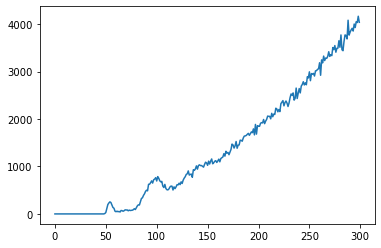

In [113]:
plt.plot(g)

In [114]:
g, r = grdf(g, ngr, bins, npart, cell)

In [115]:
print("length of g:", np.size(g))
print("values of g:", g)

length of g: 300
values of g: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.78917360e-07 1.00492820e-06 3.80070910e-06
 6.13683123e-06 6.86464930e-06 7.30532017e-06 6.65616767e-06
 4.97754779e-06 3.51401005e-06 2.99550236e-06 1.39956981e-06
 1.07361340e-06 1.31002300e-06 1.00600296e-06 1.1016855

(0.0, 8.035852187870694e-06)

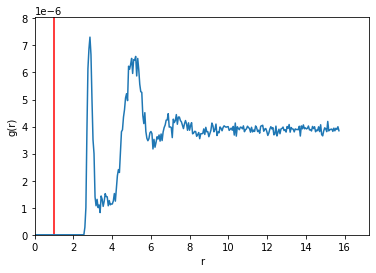

In [116]:
plt.plot(r, g)
plt.xlabel('r')
plt.vlines(1, 0, 2*np.max(g), colors="red")
plt.ylabel('g(r)')
plt.xlim( (0, np.max(r)*1.1) )
plt.ylim( (0, np.max(g)*1.1) )